In [3]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import gym
import math
from collections import namedtuple
import time
f = open('results.txt','w')


class Options:
    def __init__(self):
        #Articheture
        self.batch_size = 32 # The size of the batch to learn the Q-function
        self.image_size = 80 # Resize the raw input frame to square frame of size 80 by 80 
        
        #Trickes
        self.replay_buffer_size = 100000 # The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
        self.learning_frequency = 4 # With Freq of 1/4 step update the Q-network
        self.skip_frame = 4 # Skip 4-1 raw frames between steps
        self.internal_skip_frame = 4 # Skip 4-1 raw frames between skipped frames
        self.frame_len = 4 # Each state is formed as a concatination 4 step frames [f(t-12),f(t-8),f(t-4),f(t)]
        self.Target_update = 10000 # Update the target network each 10000 steps
        self.epsilon_min = 0.08 # Minimum level of stochasticity of policy (epsilon)-greedy
        self.annealing_end = self.replay_buffer_size # The number of step it take to linearly anneal the epsilon to it min value
        self.gamma = 0.99 # The discount factor
        self.replay_start_size = self.replay_buffer_size # Start to backpropagated through the network, learning starts
        self.no_op_max = 30 / self.skip_frame # Run uniform policy for first 30 times step of the beginning of the game
        
        #GAN training
        self.image_size_GAN = 64
        self.learning_frequency_GAN = 4
        self.batch_size_GAN = 32
        self.intrinsic_beta = .1
        self.input_variance_GAN = 7/255.
        self.d_label_switch_prob_GAN = 5e-2
        
        self.load_saved = True
        self.params_savefile = 'target_MontezumaRevengeNoFrameskip-v4_8'
        
        #otimization
        self.num_episode = 100000 # Number episode to run the algorithm
        self.lr = 0.00015 # RMSprop learning rate
        self.gamma1 = 0.95 # RMSprop gamma1
        self.gamma2 = 0.95 # RMSprop gamma2
        self.rms_eps = 0.01 # RMSprop epsilon bias
        self.ctx = mx.gpu() # Enables gpu if available, if not, set it to mx.cpu()
opt = Options()

env_name = 'MontezumaRevengeNoFrameskip-v4' # Set the desired environment
env = gym.make(env_name)
num_action = env.action_space.n # Extract the number of available action from the environment setting

manualSeed = random.randint(1, 10000) # Set the desired seed to reproduce the results
mx.random.seed(manualSeed)
attrs = vars(opt)
print (', '.join("%s: %s" % item for item in attrs.items()))

DQN = gluon.nn.Sequential()
with DQN.name_scope():
    #first layer
    DQN.add(gluon.nn.Conv2D(channels=32, kernel_size=8,strides = 4,padding = 0))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    #second layer
    DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=4,strides = 2))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    #tird layer
    DQN.add(gluon.nn.Conv2D(channels=64, kernel_size=3,strides = 1))
    DQN.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    DQN.add(gluon.nn.Activation('relu'))
    DQN.add(gluon.nn.Flatten())
    #fourth layer
    DQN.add(gluon.nn.Dense(512,activation ='relu'))
    #fifth layer
    DQN.add(gluon.nn.Dense(num_action,activation ='relu'))

dqn = DQN
dqn.load_params("target_MontezumaRevengeNoFrameskip-v4_8", ctx = opt.ctx)

noise_dim = 512
last_layer_dim = 3*3*128

def get_discriminator():
    Discriminator = gluon.nn.Sequential()
    with Discriminator.name_scope():
        #first layer
        Discriminator.add(gluon.nn.Conv2D(channels=32, kernel_size=7,strides=1))
        Discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Discriminator.add(gluon.nn.LeakyReLU(.1))
        
        #second layer
        Discriminator.add(gluon.nn.Conv2D(channels=32, kernel_size=7,strides=3))
        Discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Discriminator.add(gluon.nn.LeakyReLU(.1))
        
        #third layer
        Discriminator.add(gluon.nn.Conv2D(channels=64, kernel_size=5,strides = 1))
        Discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Discriminator.add(gluon.nn.LeakyReLU(.1))
        
        #fourth layer
        Discriminator.add(gluon.nn.Conv2D(channels=64, kernel_size=5,strides = 2))
        Discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Discriminator.add(gluon.nn.LeakyReLU(.1))
        
        #fifth layer
        Discriminator.add(gluon.nn.Conv2D(channels=128, kernel_size=3,strides = 1))
        Discriminator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Discriminator.add(gluon.nn.LeakyReLU(.1))
        Discriminator.add(gluon.nn.Flatten())
        
        #seventh layer
        Discriminator.add(gluon.nn.Dense(1, activation='sigmoid'))
    return Discriminator

D = get_discriminator()
D.load_params("disc_MontezumaRevengeNoFrameskip-v4_1", ctx = opt.ctx)

def preprocess_GAN(raw_frame):
    raw_frame = nd.array(raw_frame,mx.cpu())
    raw_frame = mx.image.imresize(raw_frame,  opt.image_size_GAN, opt.image_size_GAN)
    raw_frame = nd.transpose(raw_frame, (2,0,1))
    raw_frame = 1.8*(raw_frame.astype('float32')/255.) - .9
    return raw_frame

def preprocess(raw_frame, currentState = None, initial_state = False):
    raw_frame = nd.array(raw_frame,mx.cpu())
    raw_frame = nd.reshape(nd.mean(raw_frame, axis = 2),shape = (raw_frame.shape[0],raw_frame.shape[1],1))
    raw_frame = mx.image.imresize(raw_frame,  opt.image_size, opt.image_size)
    raw_frame = nd.transpose(raw_frame, (2,0,1))
    raw_frame = raw_frame.astype('float32')/255.
    if initial_state == True:
        state = raw_frame
        for _ in range(opt.frame_len-1):
            state = nd.concat(state , raw_frame, dim = 0)
    else:
        state = mx.nd.concat(currentState[1:,:,:], raw_frame, dim = 0)
    return state

def render_image(next_frame, reward):
    plt.title("Intrinsic Reward: "+str(reward))
    plt.imshow(next_frame)
    plt.show()
    display.clear_output(wait=True)
    #plt.pause(.02)
    
#enjoy Montezuma
next_frame = env.reset()
state = preprocess(next_frame, initial_state = True)
done = False
t = 0
intrinsic_reward = 0.
while not done:
    sample = random.random()
    render_image(next_frame, intrinsic_reward)
    effective_eps = opt.epsilon_min
    if t < opt.no_op_max:
        effective_eps = 1.
    # epsilon greedy policy
    if sample < effective_eps:
        action = random.randint(0, num_action - 1)
    else:
        data = nd.array(state.reshape([1,opt.frame_len,opt.image_size,opt.image_size]),opt.ctx)
        action = int(nd.argmax(dqn(data),axis=1).as_in_context(mx.cpu()).asscalar())
    for skip in range(opt.skip_frame-1):
        next_frame, reward, done,_ = env.step(action)
        render_image(next_frame, intrinsic_reward)
        for internal_skip in range(opt.internal_skip_frame-1):
            _ , reward, done,_ = env.step(action)
            #render_image(next_frame)
                
    next_frame_new, reward, done, _ = env.step(action)
    next_frame = np.maximum(next_frame_new,next_frame)
    frame = preprocess_GAN(next_frame)
    data_GAN = frame.reshape([1,3,opt.image_size_GAN,opt.image_size_GAN]).as_in_context(opt.ctx)
    with autograd.train_mode():
        intrinsic_reward = nd.sum(-nd.log(D(data_GAN))+1e-10).asscalar()
    state = preprocess(next_frame, currentState=state)
    t += 1

KeyboardInterrupt: 

# import sys
if not hasattr(env.action_space, 'n'):
    raise Exception('Keyboard agent only supports discrete action spaces')
ACTIONS = env.action_space.n
ROLLOUT_TIME = 1000
SKIP_CONTROL = 4    # Use previous control decision SKIP_CONTROL times, that's how you
                    # can test what skip is still usable.

human_agent_action = 0
human_wants_restart = False
human_sets_pause = False
intrinsic_reward = 0.

def rollout(env):
    global human_agent_action, human_wants_restart, human_sets_pause, intrinsic_reward
    human_wants_restart = False
    obser = env.reset()
    skip = 0
    for t in range(ROLLOUT_TIME):
        if not skip:
            a = int(input('nextaction'))
            #print("taking action {}".format(human_agent_action))
            skip = SKIP_CONTROL
        else:
            skip -= 1
        #env.render()
        obser, r, done, info = env.step(a)
        render_image(obser, intrinsic_reward)
        frame = preprocess_GAN(obser)
        data_GAN = frame.reshape([1,3,opt.image_size_GAN,opt.image_size_GAN]).as_in_context(opt.ctx)
        with autograd.train_mode():
            intrinsic_reward = nd.sum(-nd.log(D(data_GAN))+1e-10).asscalar()
        
        if done: break
        if human_wants_restart: break
        while human_sets_pause:
            env.render()
            import time
            time.sleep(0.1)

print("ACTIONS={}".format(ACTIONS))
print("Press keys 1 2 3 ... to take actions 1 2 3 ...")
print("No keys pressed is taking action 0")

while 1:
    rollout(env)

/usr/lib64/python3.4/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


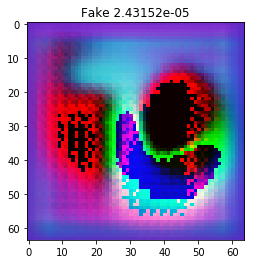

In [4]:
class Reshape(gluon.nn.Block):
    def __init__(self, **kwargs):
        size = kwargs.pop("dims")
        super(Reshape, self).__init__(**kwargs)
        with self.name_scope():
            self.size = size
            
    def forward(self,x):
        return x.reshape((x.shape[0],)+(self.size))
            
def get_generator():
    Generator = gluon.nn.Sequential()
    with Generator.name_scope():
        #first layer
        Generator.add(gluon.nn.Dense(last_layer_dim,activation ='relu'))
        Generator.add(Reshape(dims=(128,3,3)))

        #second layer
        Generator.add(gluon.nn.Conv2DTranspose(channels=64, kernel_size=3,strides = 1))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Activation('relu'))

        #third layer
        Generator.add(gluon.nn.Conv2DTranspose(channels=64, kernel_size=6,strides = 2))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Activation('relu'))

        #fourth layer
        Generator.add(gluon.nn.Conv2DTranspose(channels=32, kernel_size=5,strides = 1))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Activation('relu'))
        
        #fifth layer
        Generator.add(gluon.nn.Conv2DTranspose(channels=32, kernel_size=7,strides = 3))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Activation('relu'))
        
        #sixth layer
        Generator.add(gluon.nn.Conv2DTranspose(channels=3, kernel_size=7,strides = 1))
        Generator.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
        Generator.add(gluon.nn.Activation('tanh'))
    return Generator
G = get_generator()
G.load_params("gen_MontezumaRevengeNoFrameskip-v4_0", ctx = opt.ctx)
def show_generator(score_fake, frame_fake):
    print_frame_fake = (255.*(frame_fake+.9)/1.8).astype('uint8').asnumpy()
    print_frame_fake = np.transpose(print_frame_fake, (1,2,0)) 
    fig = plt.figure()
    imgplot2 = plt.imshow(print_frame_fake)
    a2 = fig.add_subplot(1,1,1)
    a2.set_title("Fake "+str(score_fake))
    plt.show()
    
z = nd.random.normal(shape=(1,noise_dim), ctx=opt.ctx)
fake_frame = G(z)
show_generator(nd.sum(D(fake_frame)).asscalar(), fake_frame[0])